In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
print("TensorFlow Version:", tf.__version__)
print("Numpy Version:", np.__version__)

TensorFlow Version: 2.17.0
Numpy Version: 1.26.4


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Data Loading

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=6c71f3fa-6cfc-46bf-9a57-53eb39971c6c
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 120MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['a','t','h','a','r','v','a'])

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 1, 20,  8,  1, 18, 22,  1])>

In [ ]:
num_to_char([1, 20, 8, 1, 18, 22, 1])

<tf.Tensor: shape=(7,), dtype=string, numpy=array([b'a', b't', b'h', b'a', b'r', b'v', b'a'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

Loading - Testing

In [ ]:
test_path = r'./content/data/s1/bbaf2n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

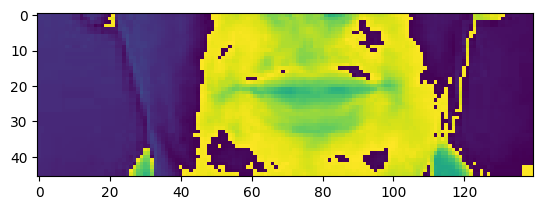

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(50, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
# train = data.take(400)
# test = data.skip(400).take(100)
train = data.take(300)
test = data.skip(300).take(100)
# train = train.prefetch(tf.data.AUTOTUNE)
# test = test.prefetch(tf.data.AUTOTUNE)

# train = data.take(15)
# test = data.skip(15).take(5)

In [ ]:
len(train)

300

In [ ]:
len(test)

100

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.2988578 ],
          [ 1.2988578 ],
          [ 1.3382171 ],
          ...,
          [ 9.367519  ],
          [ 9.9185505 ],
          [ 9.9185505 ]],

         [[ 1.2988578 ],
          [ 1.2988578 ],
          [ 1.3382171 ],
          ...,
          [ 9.367519  ],
          [ 9.9185505 ],
          [ 9.800472  ]],

         [[ 1.2988578 ],
          [ 1.2988578 ],
          [ 1.2594985 ],
          ...,
          [ 9.997269  ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9052645 ],
          [ 0.9052645 ],
          [ 0.9052645 ],
          ...,
          [ 9.9185505 ],
          [ 9.879191  ],
          [ 9.879191  ]],

         [[ 0.9052645 ],
          [ 0.9052645 ],
          [ 0.9052645 ],
          ...,
          [ 9.800472  ],
          [ 9.800472  ],
          [ 9.800472  ]],

         [[ 0.9052645 ],
          [ 0.9052645 ],
          [ 0.9052645 ],
          ...,
          [ 9.800472  ],
          [ 9.800472  ],
          

In [ ]:
array = val[0][1]

# Ensure the array is in uint8 format
if array.dtype != np.uint8:
    array = (255 * (array - np.min(array)) / (np.max(array) - np.min(array))).astype(np.uint8)

# If the array has a single channel (e.g., (frames, height, width, 1)), convert to RGB by stacking
if array.shape[-1] == 1:
    array = np.repeat(array, 3, axis=-1)  # Repeat the single channel three times

# Debugging step: print the array shape and dtype to confirm it's correct
print(f"Array shape after conversion: {array.shape}, Array dtype: {array.dtype}")

# Save the array as a GIF
# imageio.mimsave('./animation_sample.gif', array, fps=10)

Array shape after conversion: (75, 46, 140, 3), Array dtype: uint8


In [ ]:
alignments

array([[16, 12,  1,  3,  5, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 11,
        39, 15, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 18,  5,  4, 39,  9, 14, 39,  8, 39, 15, 14,  5,
        39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

Pipeline - Testing

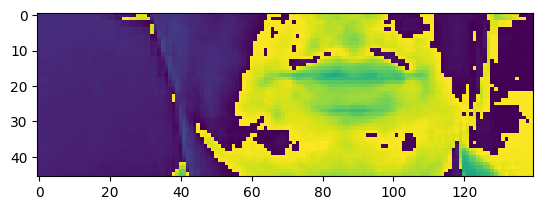

In [ ]:
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with o three soon'>

Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Reshape((-1,))))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.3))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.3))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 75, 46, 140, 128)    │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 75, 23, 70, 256)     │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 75, 11, 35, 75)      │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,473,760 (32.32 MB)

 Trainable params: 8,472,842 (32.32 MB)

 Non-trainable params: 918 (3.59 KB)

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuuuuuuudddddddddddddddddddddddddddddddhhhhhhhhhhhhhhhooooooooooooooooqqq55'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuuuuuuudddddddddddddddddddddddddddddddhhhhhhhhhhhhhhhooooooooooooooooqqq55'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1).numpy())
        # return lr * tf.math.exp(-0.1)
        # return lr * 0.5 ** (epoch // 30)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def CTCAccuracy(y_true, y_pred):
    # Cast to proper types
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    time_steps = tf.cast(tf.shape(y_pred)[1], dtype="int64")

    # Create input lengths for each sample in the batch
    input_length = tf.fill([batch_len], time_steps)

    # Decode predictions using CTC
    decoded_pred, _ = tf.keras.backend.ctc_decode(y_pred, input_length=input_length, greedy=True)
    decoded_pred = decoded_pred[0]  # Get the first decoded output

    # Ensure y_true is in dense format and properly cast
    y_true_dense = tf.cast(y_true, dtype=tf.int64)

    # Get the maximum lengths of true and predicted sequences
    max_len_true = tf.shape(y_true_dense)[1]
    max_len_pred = tf.shape(decoded_pred)[1]

    # Pad or truncate decoded_pred based on its length relative to y_true_dense
    decoded_pred = tf.cond(
        max_len_pred < max_len_true,
        lambda: tf.pad(decoded_pred, [[0, 0], [0, max_len_true - max_len_pred]], constant_values=-1),
        lambda: decoded_pred[:, :max_len_true]
    )

    # Compare the true labels with predicted ones to compute accuracy
    accuracy_per_sample = tf.reduce_mean(
        tf.cast(tf.equal(y_true_dense, decoded_pred), dtype=tf.float32),
        axis=-1  # Compute accuracy along the time step dimension
    )

    # Compute mean accuracy over the batch
    mean_accuracy = tf.reduce_mean(accuracy_per_sample)

    return mean_accuracy


In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # train_acc = CategoricalAccuracy(name='train_accuracy')
        # val_acc = CategoricalAccuracy(name='val_accuracy')
        batch_size = tf.shape(yhat)[0].numpy()
        time_steps = tf.shape(yhat)[1]
        input_length = np.full(shape=(batch_size,), fill_value=time_steps)
        # decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=input_length, greedy=False)
        decoded = decoded[0].numpy()
        for x in range(batch_size):
            # print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            # print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            # print('~'*100)
            original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
            prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
            print(f'Original: {original}')
            print(f'Prediction: {prediction}')
            print('~' * 100)

In [ ]:
# from sklearn.metrics import accuracy_score
# class ProduceExample(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.epoch_accuracies = []
#         self.epoch_losses = []

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         # Record loss
#         if 'loss' in logs:
#             self.epoch_losses.append(logs['loss'])
#         else:
#             self.epoch_losses.append(None)

#         # Record accuracy
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         batch_size = tf.shape(yhat)[0].numpy()
#         time_steps = tf.shape(yhat)[1]
#         input_length = np.full(shape=(batch_size,), fill_value=time_steps)

#         # Decode predictions
#         decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=input_length, greedy=False)
#         decoded = decoded[0].numpy()

#         # Initialize lists to store true labels and predictions
#         original_labels = []
#         predicted_labels = []

#         for x in range(batch_size):
#             original = tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8')
#             prediction = tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8')
#             original_labels.append(original)
#             predicted_labels.append(prediction)

#             # Print the original and predicted sentences
#             print(f'Original: {original}')
#             print(f'Prediction: {prediction}')
#             print('~' * 100)

#         # Flatten labels and predictions
#         flat_original = [label for sentence in original_labels for label in sentence.split()]
#         flat_prediction = [pred for sentence in predicted_labels for pred in sentence.split()]

#         # Handle length mismatch
#         min_length = min(len(flat_original), len(flat_prediction))
#         if min_length > 0:
#             flat_original = flat_original[:min_length]
#             flat_prediction = flat_prediction[:min_length]
#             accuracy = accuracy_score(flat_original, flat_prediction)
#             self.epoch_accuracies.append(accuracy)
#             print(f'Epoch {epoch + 1} Accuracy: {accuracy:.4f}')
#         else:
#             self.epoch_accuracies.append(0)
#             print(f'Epoch {epoch + 1} - No valid data for accuracy calculation.')

#     def get_accuracies(self):
#         return self.epoch_accuracies

#     def get_losses(self):
#         return self.epoch_losses

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss, metrics=[CTCAccuracy])

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint3.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
history = model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original: bin blue by s four now
Prediction: l e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by x four please
Prediction: l e e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
400/400 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - ctc_accuracy: 0.0238 - loss: 97.0697 - val_ctc_accuracy: 0.0064 - val_loss: 70.6677 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Original: set red in n six please
Prediction: la e e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with x one soon
Prediction: la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
400/400 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - ctc_accuracy: 0.0476 - loss: 70.3819 - val_ctc_accuracy:

In [ ]:
history = model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original: place blue in u nine soon
Prediction: l e e e e 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in j nine soon
Prediction: l e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
300/300 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - ctc_accuracy: 0.0129 - loss: 105.9996 - val_ctc_accuracy: 0.0061 - val_loss: 73.8284 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Original: lay blue in q three again
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with t two please
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
300/300 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - ctc_accuracy: 0.0387 - loss: 73.3633 - val_ctc_accu